In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [2]:
embeddings = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=20000)#np.load("data_full/embeddings_full.npy")
vocab = pickle.load(open("data_full/vocab.pkl",'rb'))

In [4]:
vocab

{'<user>': 0,
 '!': 1,
 'i': 2,
 'the': 3,
 '.': 4,
 ',': 5,
 'to': 6,
 'you': 7,
 '(': 8,
 '<url>': 9,
 'a': 10,
 '...': 11,
 'and': 12,
 'my': 13,
 'me': 14,
 'of': 15,
 '?': 16,
 'is': 17,
 'for': 18,
 'in': 19,
 'it': 20,
 '"': 21,
 'this': 22,
 'on': 23,
 'with': 24,
 'that': 25,
 'so': 26,
 '-': 27,
 ')': 28,
 'be': 29,
 'have': 30,
 "i'm": 31,
 ':': 32,
 'but': 33,
 'just': 34,
 'rt': 35,
 'your': 36,
 'love': 37,
 'not': 38,
 'was': 39,
 'are': 40,
 '..': 41,
 'like': 42,
 'at': 43,
 'all': 44,
 '/': 45,
 'get': 46,
 'frame': 47,
 'up': 48,
 '&': 49,
 'u': 50,
 'lol': 51,
 'good': 52,
 'know': 53,
 'do': 54,
 'when': 55,
 'one': 56,
 'now': 57,
 'we': 58,
 'follow': 59,
 'if': 60,
 'no': 61,
 'can': 62,
 'go': 63,
 "don't": 64,
 'what': 65,
 'will': 66,
 'out': 67,
 'please': 68,
 'day': 69,
 'too': 70,
 'from': 71,
 'see': 72,
 'want': 73,
 "'": 74,
 'back': 75,
 "it's": 76,
 'thanks': 77,
 'how': 78,
 'x': 79,
 'about': 80,
 'time': 81,
 'got': 82,
 'really': 83,
 'its': 84,


In [3]:
VECT_DIM = 50

In [7]:
t_pos = pd.read_table("data/train_pos.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_pos['label'] = 1
t_neg = pd.read_table("data/train_neg.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_neg['label'] = 0
df = pd.concat((t_pos,t_neg))

In [8]:
def vectorize(tweets):
    vectorized_tweets_np = np.zeros((len(tweets),VECT_DIM))
    for i, tweet in enumerate(tqdm(tweets)):
        tweet_len = len(tweet.split(' '))
        tweet_embedding=np.zeros((tweet_len,VECT_DIM))
        for j, word in enumerate(tweet.split(' ')):
            if word not in vocab.keys():
                continue
            tweet_embedding[j] = embeddings[word]
        vectorized_tweets_np[i] = tweet_embedding.mean(0)
    return vectorized_tweets_np

In [9]:
X = vectorize(df.tweet)
y = df['label'].values

100%|██████████| 196970/196970 [01:40<00:00, 1964.50it/s]


In [10]:
X.shape

(196970, 50)

In [11]:
class TrainDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.y_data[index], self.X_data[index] 

    def __len__(self):
        return len(self.X_data)

In [12]:
class TestDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
    
    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [14]:
train_data = TrainDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
test_data = TrainDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

In [15]:
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
        train_loss, correct = 0,0
        for y_batch, X_batch in tqdm(dataloader):

                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)

                train_loss += loss.item()
                correct += (pred.argmax(1) == y_batch).type(torch.float).sum().item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        train_loss /= len(dataloader)
        correct /= len(dataloader.dataset)
        print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
        return train_loss, correct

In [17]:
def test_loop(dataloader, model, loss_fn):
    test_loss, correct = 0,0
    with torch.no_grad():
        for y, X in dataloader:

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct



In [18]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_accs, test_accs = [], [], []
    for epoch in range(num_epochs):
        print(f"Epoch : {epoch+1}\n")
        train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc = test_loop(test_loader, model, loss_fn)
        losses.append(float(train_loss))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    plt.title("Training")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()



In [21]:
model = nn.Sequential(nn.Linear(50, 40),
                        nn.ReLU(),
                        nn.Linear(40, 20),
                        nn.ReLU(),
                        nn.Linear(20, 2))

Epoch : 1



100%|██████████| 1232/1232 [00:05<00:00, 206.12it/s]


Train Error: 
 Accuracy: 69.7%, Avg loss: 0.550897 

Test Error: 
 Accuracy: 70.7%, Avg loss: 0.542571 

Epoch : 2



100%|██████████| 1232/1232 [00:05<00:00, 217.77it/s]


Train Error: 
 Accuracy: 71.4%, Avg loss: 0.529823 

Test Error: 
 Accuracy: 71.4%, Avg loss: 0.533721 

Epoch : 3



100%|██████████| 1232/1232 [00:05<00:00, 216.07it/s]


Train Error: 
 Accuracy: 71.9%, Avg loss: 0.523042 

Test Error: 
 Accuracy: 72.2%, Avg loss: 0.523941 

Epoch : 4



100%|██████████| 1232/1232 [00:06<00:00, 184.93it/s]


Train Error: 
 Accuracy: 72.3%, Avg loss: 0.517997 

Test Error: 
 Accuracy: 71.9%, Avg loss: 0.524304 

Epoch : 5



100%|██████████| 1232/1232 [00:05<00:00, 226.83it/s]


Train Error: 
 Accuracy: 72.4%, Avg loss: 0.515118 

Test Error: 
 Accuracy: 72.3%, Avg loss: 0.524222 

Epoch : 6



100%|██████████| 1232/1232 [00:05<00:00, 228.14it/s]


Train Error: 
 Accuracy: 72.7%, Avg loss: 0.512482 

Test Error: 
 Accuracy: 72.8%, Avg loss: 0.514768 

Epoch : 7



100%|██████████| 1232/1232 [00:05<00:00, 229.14it/s]


Train Error: 
 Accuracy: 73.0%, Avg loss: 0.508424 

Test Error: 
 Accuracy: 72.6%, Avg loss: 0.518619 

Epoch : 8



100%|██████████| 1232/1232 [00:05<00:00, 236.53it/s]


Train Error: 
 Accuracy: 73.1%, Avg loss: 0.507359 

Test Error: 
 Accuracy: 72.4%, Avg loss: 0.516704 

Epoch : 9



100%|██████████| 1232/1232 [00:05<00:00, 238.78it/s]


Train Error: 
 Accuracy: 73.3%, Avg loss: 0.505307 

Test Error: 
 Accuracy: 72.5%, Avg loss: 0.515054 

Epoch : 10



100%|██████████| 1232/1232 [00:05<00:00, 240.61it/s]


Train Error: 
 Accuracy: 73.3%, Avg loss: 0.503709 

Test Error: 
 Accuracy: 72.7%, Avg loss: 0.511754 



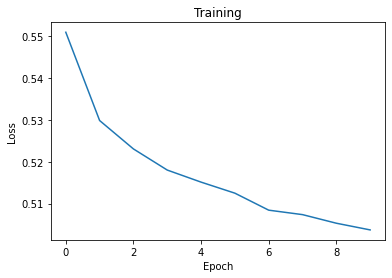

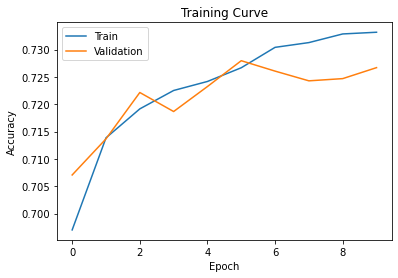

In [22]:
train(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-2)

In [25]:
def prepare(tweet):
    tweet_len = len(tweet.split(' '))
    tweet_embedding=np.zeros((tweet_len,VECT_DIM))
    for j, word in enumerate(tweet.split(' ')):
        if word not in vocab.keys():
            continue
        tweet_embedding[j] = embeddings[word]
    return tweet_embedding.mean(0)

In [40]:
torch.argmax(model(torch.FloatTensor(prepare("I am Happy"))))

tensor(1)